In [ ]:
import numpy as np
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import cv2
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.autograd import Variable
from IPython.display import HTML
from torch.optim.lr_scheduler import StepLR
from scipy import linalg, statscc
from torch.utils.data import DataLoader, TensorDataset, Subset
import tqdm
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
from torchsummary import summary
import matplotlib.animation as animation
from torch.distributions import Categorical

In [ ]:
# Note that we divide by five because each batch contains x5 within bc of fivecrop
batch_size = 128//5
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 32

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
device

In [ ]:
from datasets import load_from_disk
portrait_data = load_from_disk('/content/drive/MyDrive/cv2/wikiart_portrait')

In [ ]:
num_style_classes = len(set(portrait_data['style']))
original_indices = [0, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
consecutive_indices = {original_indices[i]: i for i in range(len(original_indices))}

In [ ]:
from torchvision.transforms.functional import five_crop
from torchvision.transforms.functional import resize
from PIL import Image

transform = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Lambda(lambda x: five_crop(x, (int(x.shape[1]*0.9), int(x.shape[2]*0.9)))),
                               transforms.Lambda(lambda crops: [resize(crop, (64, 64)) for crop in crops]),
                               transforms.Lambda(lambda crops: torch.stack([crop for crop in crops])),
                           ])

def apply_transform(examples):
    examples['image'] = [transform(image) for image in examples['image']]
    examples['style'] = [torch.stack([torch.tensor(consecutive_indices[style])]*5) for style in examples['style']]
    return examples

In [ ]:
ds = portrait_data.with_format("torch")
ds = portrait_data.with_transform(apply_transform)

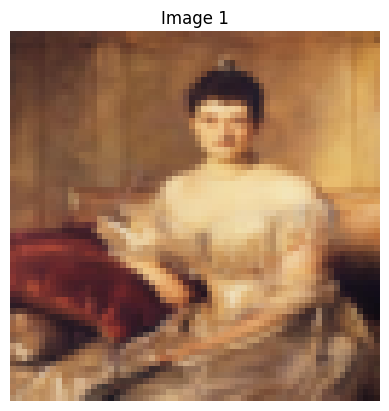

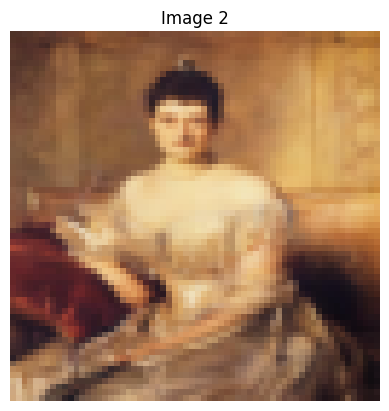

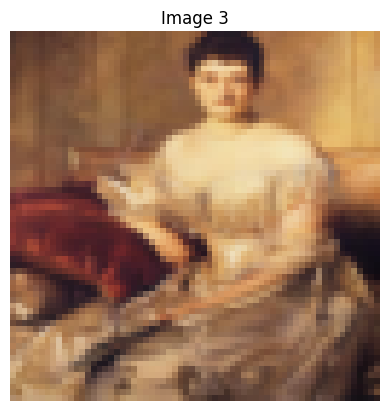

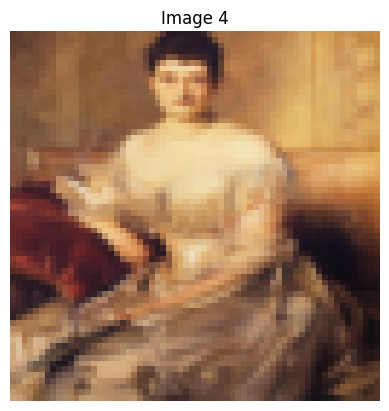

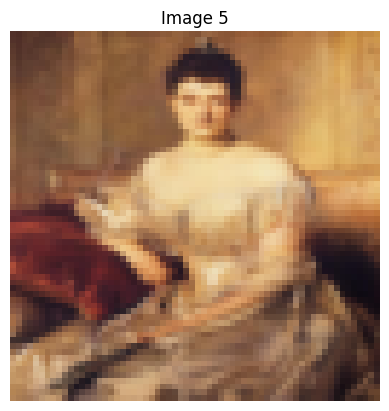

In [ ]:
import matplotlib.pyplot as plt
import torchvision

batch = ds[145]['image']

b = batch.size(0)

for i in range(b):
    image = batch[i].permute(1, 2, 0)
    image_np = image.cpu().numpy()
    plt.imshow(image_np)
    plt.axis('off')
    plt.title(f"Image {i+1}")
    plt.show()

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64, output_size=1, num_style_classes=num_style_classes):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Real/fake head
        self.real_fake_head = nn.Sequential(
            nn.Conv2d(ndf * 8, output_size, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

        # Multi-label head
        self.multi_label_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8192, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, num_style_classes),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.main(x)
        real_fake_output = self.real_fake_head(x)
        multi_label_output = self.multi_label_head(x)
        return real_fake_output.view(-1, 1), multi_label_output



latent_dim = 100
g=Generator()
batchsize=2
z = torch.randn(batchsize, latent_dim, 1, 1)
out = g(z)
print(out.size())



d=Discriminator()
x=torch.randn((batchsize, 3, 64, 64))
out = d(x)
print(out[0].size(), out[1].size())

torch.Size([2, 3, 64, 64])
torch.Size([2, 1]) torch.Size([2, 24])


In [ ]:
def collate_fn(examples):
    images = []
    labels = []
    for example in examples:
        images.append((example["image"]))
        labels.append((example["style"]))
    pixel_values = torch.stack(images)
    labels = torch.cat(labels, dim=0)
    return {"image": pixel_values, "style": labels}

dataloader = DataLoader(ds, collate_fn=collate_fn, batch_size=batch_size)

In [ ]:
num_epochs = 1000
lr = 0.0001
beta1 = 0.5

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
criterion_rf = nn.BCELoss()
criterion_mc = nn.CrossEntropyLoss()

fixed_noise = torch.randn(batch_size, latent_dim ,1, 1, device=device)

real_label = 1.
fake_label = 0.

netD = Discriminator().to(device)
netD.apply(weights_init)
netG = Generator().to(device)
netG.apply(weights_init)

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
print(summary(netG,(100,1,1)))
print(summary(netD,(3, image_size, image_size)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [ ]:
def image_entropy(probs):
    return sum(Categorical(probs = probs).entropy())/probs.size(0)

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(num_epochs):

    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch

        # real, label_mc = data
        real = data["image"].to(device)
        real = real.view(-1, real.size(2), real.size(3), real.size(4))

        label_mc = data["style"].to(device)

        b_size = real.size(0)

        # we have to repeat the class labels bc five_crop transformation creates five copies of the same image
        label_mc = label_mc.view(-1)

        label_rf = torch.full((b_size,), real_label, dtype=torch.float, device=device)


        # Forward pass real batch through D
        output_rf, output_mc = netD(real)

        output_rf = output_rf.view(-1)
        # output_mc = output_mc.view(-1)

        # Calculate real/fake loss on all-real batch
        errD_real_rf = criterion_rf(output_rf, label_rf)
        # Calculate gradients for D in backward pass
        errD_real_rf.backward(retain_graph=True)

        # Calculate multiclass loss on all-real batch
        errD_real_mc = criterion_mc(output_mc, label_mc)
        # Calculate gradients for D, (summed) with previous gradients
        errD_real_mc.backward()


        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_dim, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label_rf.fill_(fake_label)
        # Classify all fake batch with D
        output_rf, _ = netD(fake.detach())

        output_rf = output_rf.view(-1)

        # Calculate D's real/fake loss on the all-fake batch
        errD_fake_rf = criterion_rf(output_rf, label_rf)
        errD_fake_rf.backward()

        # Compute error of D as sum of the fake and the real batches for real/fake loss and the real multiclass loss
        errD = errD_real_rf + errD_fake_rf + errD_real_mc

        # Update D
        optimizerD.step()


        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################

        netG.zero_grad()
        label_rf.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D

        output_rf, output_mc = netD(fake)

        output_rf = output_rf.view(-1)
        # output_mc = output_mc.view(-1)


        # Calculate G's real/fake loss based on this output
        errG_rf = criterion_rf(output_rf, label_rf)
        # Calculate gradients for G
        errG_rf.backward(retain_graph=True)

        # Calculate G's mutliclass loss i.e. how good G is at making D struggle to categorize the generated art.
        # Note that we have a negative sign, as G wants this value to be large.
        # errG_mc = torch.tensor(b_size*np.log(used_labels), device=device) - image_entropy(output_mc)
        errG_mc = np.log(num_style_classes) - image_entropy(output_mc)
        # print('ERRG_MC: {}'.format(errG_mc))
        # print('log: {}'.format(torch.log(torch.tensor(b_size))))
        errG_mc.backward()

        errG = errG_rf + errG_mc

        # Update G
        optimizerG.step()

        # Output training stats
        if i % 10 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item()))
            with open("/content/drive/MyDrive/cv2/scaled_creative_bs_128.txt", "a+") as file:
              # Append the print statement
              file.write('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\n' %
                        (epoch, num_epochs, i, len(dataloader), errD.item(), errG.item()))

    # Check if it's time to save the models
    if (epoch + 1) % 10 == 0:
        # Create a checkpoint dictionary containing the state dictionaries of the models
        checkpoint = {'netG': netG.state_dict(),
                      'netD': netD.state_dict()}

        # Save the checkpoint to a file with a name indicating the epoch
        torch.save(checkpoint, '/content/drive/MyDrive/cv2/scaled_creative_bs_128_epoch_{}.pt'.format(epoch + 1))


Streaming output truncated to the last 5000 lines.
[21/1000][440/565]	Loss_D: 3.2397	Loss_G: 7.3473
[21/1000][450/565]	Loss_D: 3.7805	Loss_G: 7.3952
[21/1000][460/565]	Loss_D: 3.5185	Loss_G: 6.0053
[21/1000][470/565]	Loss_D: 3.5916	Loss_G: 5.1749
[21/1000][480/565]	Loss_D: 3.3858	Loss_G: 6.1426
[21/1000][490/565]	Loss_D: 3.5168	Loss_G: 5.7680
[21/1000][500/565]	Loss_D: 3.6745	Loss_G: 5.3933
[21/1000][510/565]	Loss_D: 4.3982	Loss_G: 3.8934
[21/1000][520/565]	Loss_D: 3.8973	Loss_G: 7.6345
[21/1000][530/565]	Loss_D: 3.9108	Loss_G: 7.9875
[21/1000][540/565]	Loss_D: 3.7991	Loss_G: 6.5574
[21/1000][550/565]	Loss_D: 3.2424	Loss_G: 6.0151
[21/1000][560/565]	Loss_D: 3.7498	Loss_G: 4.5495
[22/1000][0/565]	Loss_D: 3.3650	Loss_G: 6.6451
[22/1000][10/565]	Loss_D: 3.4694	Loss_G: 4.1650
[22/1000][20/565]	Loss_D: 3.5177	Loss_G: 5.6385
[22/1000][30/565]	Loss_D: 3.0982	Loss_G: 5.9844
[22/1000][40/565]	Loss_D: 3.3010	Loss_G: 5.5223
[22/1000][50/565]	Loss_D: 3.2237	Loss_G: 6.2355
[22/1000][60/565]	Loss_D: